In [1]:
import numpy as np
import openslide
from openslide import deepzoom
import matplotlib.pyplot as plt
import random
import utility_functions as uf
import torch
import os
from PIL import Image
import xlrd
import time


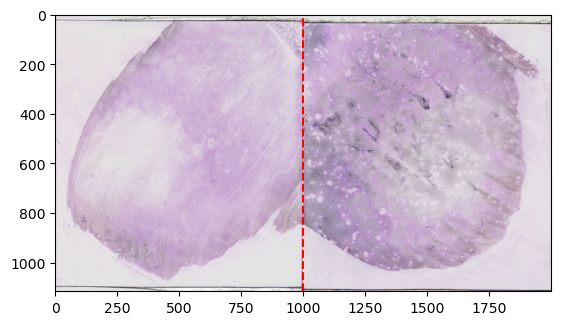

In [3]:
slide_num = 1001
left_proportion = 0.5
slidePath = "/home/exon_storage1/aml_slide/renameByUPN/A{}.ndpi".format(slide_num)
slide = openslide.open_slide(slidePath)
simg = np.array(slide.get_thumbnail((2000, 2000)))
plt.imshow(simg)
#plot a line seperating right and left with a proportion 0.65
plt.axvline(x=2000*left_proportion, color='r', linestyle='--')

In [ ]:
with openslide.OpenSlide(slidePath) as slide:
  print(slide.level_count) # 幾種分辨率
  # print(slide.dimensions) #最高分辨率下的(width, height)
  print(slide.level_dimensions) #所有分辨率的(width,height)
  # print(slide.level_downsamples) # 每個分辨的倍數關係，即level_dimension[k] = dimensions / level_downsamples[k]

In [ ]:
slide_level = 6 # 0 ~ 9
with openslide.OpenSlide(slidePath) as slide:
  # 切出切出右側的圖片
  dims = slide.level_dimensions
  level_dim = list(dims[slide_level])
  level_dim[0] = int(level_dim[0]*(1-left_proportion))
  split_x =int(dims[0][0]*left_proportion)
  level6_img_RGB = slide.read_region((split_x,0),slide_level,level_dim).convert("RGB")
  #save image as new png file
  # level6_img_RGB.save("split_slide.png")
  # 讀入原始圖片
  image = level6_img_RGB
  # 取得原始圖片的寬度和高度
  width, height = image.size
  # 計算要裁剪的區域
  shrink_proportion = 0.15
  left = int(width * 0)
  right = int(width *(1-shrink_proportion))
  top = int(height * shrink_proportion)
  bottom = int(height * (1-shrink_proportion))
  # 進行裁剪
  cropped_image = image.crop((left, top, right, bottom))
  # 保存裁剪後的圖片
  # cropped_image.save('cropped_image.jpg')
  # 顯示裁剪前與後的圖片
  simg = np.array(level6_img_RGB)
  simg2 = np.array(cropped_image)
  # 設定子圖
  fig = plt.figure(dpi = 1000)
  fig, axes = plt.subplots(nrows=1, ncols=2)
  # 在第一個子圖中顯示第一張圖片
  axes[0].imshow(simg)
  axes[0].set_title('original image')
  # 在第二個子圖中顯示第二張圖片
  axes[1].imshow(simg2)
  axes[1].set_title('cropped image')
  #圖片顯示不要座標
  axes[0].set_xticks([])
  axes[0].set_yticks([])
  axes[1].set_xticks([])
  axes[1].set_yticks([])
  # 在圖片上標註出裁剪的區域
  axes[0].add_patch(plt.Rectangle((left, top), right - left, bottom - top, fill=False, edgecolor='red', linewidth=2))
  plt.tight_layout()
  #第一個子圖不要外匡
  axes[0].spines['top'].set_visible(False)
  axes[0].spines['right'].set_visible(False)
  axes[0].spines['bottom'].set_visible(False)
  axes[0].spines['left'].set_visible(False)
  #第二個子圖不要外匡
  axes[1].spines['top'].set_visible(False)
  axes[1].spines['right'].set_visible(False)
  axes[1].spines['bottom'].set_visible(False)
  axes[1].spines['left'].set_visible(False)
  #第二張圖片紅色外匡
  axes[1].add_patch(plt.Rectangle((0, 0), right - left, bottom - top, fill=False, edgecolor='red', linewidth=4))
  # 儲存圖片
  plt.savefig('/home/weber50432/AML_image_processing/imgs/cropped_image.png')
  # 顯示圖片窗口
  plt.show()



In [ ]:
# with openslide.OpenSlide("/home/weber50432/AML_image_processing/bone_marrow_preselect/Data/A13.ndpi") as slide:
#   print(slide.dimensions) #最高分辨率下的(width, height)
#   region = slide.read_region((640*301, 640*36), 0, (640, 640)).convert("RGB")
#   plt.imshow(region)
#   plt.show()

# check training data

In [ ]:
gene = "ITD"
slide_num1 = 13 # 0 for random
lib_train = torch.load("/home/weber50432/AML_image_processing/lib/{}/{}_train_data.pt".format(gene,gene))
if slide_num1 == 0:
    index = random.randint(0,len(lib_train["slides"]))
else:
    index = lib_train["slides"].index( "/home/exon_storage1/aml_slide/renameByUPN/A{}.ndpi".format(slide_num1))
patch_list = lib_train["grid"][index]
print(lib_train["slides"][index])
print("the number of patches are:",len(patch_list))
output_unit = 10
# patch_list = uf.get_grid("/home/exon_storage1/aml_slide/",[413],256,0.65,0.15)
random_patch = random.sample(patch_list, output_unit*output_unit)
print(random_patch[:output_unit])
f, axarr = plt.subplots(output_unit, output_unit , sharex=True, sharey=True,figsize=(output_unit,output_unit))
for ax in axarr.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
k = 0
with openslide.OpenSlide(slidePath) as slide:
    for i in random_patch:
        sig = slide.read_region(i, 0, (256, 256))
        axarr[int(k/output_unit),k%output_unit].imshow(sig)
        k += 1

# check validation data

In [ ]:
gene = "ITD"
slide_num2 = 0 # 0 for random
lib_val = torch.load("/home/weber50432/AML_image_processing/lib/{}/{}_val_data.pt".format(gene,gene))
if slide_num2 == 0:
    index = random.randint(0,len(lib_val["slides"]))
else:
    index = lib_val["slides"].index("/home/exon_storage1/aml_slide/renameByUPN/A{}.ndpi".format(slide_num2))
patch_list = lib_val["grid"][index]
print(lib_val["slides"][index])
output_unit = 5
# patch_list = uf.get_grid("/home/exon_storage1/aml_slide/",[413],256,0.65,0.15)
random_patch = random.sample(patch_list, output_unit*output_unit)
print(random_patch[:output_unit])
print("the number of patches are:",len(patch_list))
f, axarr = plt.subplots(output_unit, output_unit , sharex=True, sharey=True,figsize=(output_unit,output_unit))
for ax in axarr.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
k = 0
with openslide.OpenSlide(slidePath) as slide:
    for i in random_patch:
        sig = slide.read_region(i, 0, (256, 256))
        axarr[int(k/output_unit),k%output_unit].imshow(sig)
        k += 1

# check test data

In [ ]:
gene = "ITD"
slide_num3 = 0 # 0 for random
lib_test = torch.load("/home/weber50432/AML_image_processing/lib/{}/{}_test_data.pt".format(gene,gene))
if slide_num3 == 0:
    index = random.randint(0,len(lib_test["slides"]))
else:
    index = lib_test["slides"].index("/home/exon_storage1/aml_slide/renameByUPN/A{}.ndpi".format(slide_num3))
patch_list = lib_test["grid"][index]
print(lib_test["slides"][index])
print("the number of patches are:",len(patch_list))
output_unit = 5
# patch_list = uf.get_grid("/home/exon_storage1/aml_slide/",[413],256,0.65,0.15)
random_patch = random.sample(patch_list, output_unit*output_unit)
print(random_patch[:5])
f, axarr = plt.subplots(output_unit, output_unit , sharex=True, sharey=True,figsize=(output_unit,output_unit))
for ax in axarr.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
k = 0
with openslide.OpenSlide(slidePath) as slide:
    for i in random_patch:
        sig = slide.read_region(i, 0, (256, 256))
        axarr[int(k/output_unit),k%output_unit].imshow(sig)
        k += 1

In [3]:
directory_path = '/home/weber50432/AML_image_processing/HCT_region_select/output/A13/'
exel_source = directory_path + '\porduction_result.xls'
wb = xlrd.open_workbook(exel_source)
sheet = wb.sheet_by_index(0)
patch_list = sheet.col_values(0)
patch_list.pop(0)
print("the number of patches are:",len(patch_list))
output_unit = 16
# patch_list = uf.get_grid("/home/exon_storage1/aml_slide/",[413],256,0.65,0.15)
random_patch = random.sample(patch_list, output_unit*output_unit)
print(random_patch[:output_unit])
f, axarr = plt.subplots(output_unit, output_unit , sharex=True, sharey=True,figsize=(output_unit,output_unit))
for ax in axarr.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
k = 0
for i in random_patch:
    # img_path = os.path.join(directory_path,i)
    sig = Image.open(i)
    axarr[int(k/output_unit),k%output_unit].imshow(sig)
    k += 1

the number of patches are: 928
['/home/exon_storage1/aml_slide/patches/A13/rightside_patch//A13_30132.png', '/home/exon_storage1/aml_slide/patches/A13/rightside_patch//A13_28175.png', '/home/exon_storage1/aml_slide/patches/A13/rightside_patch//A13_70799.png', '/home/exon_storage1/aml_slide/patches/A13/rightside_patch//A13_36783.png', '/home/exon_storage1/aml_slide/patches/A13/rightside_patch//A13_28505.png', '/home/exon_storage1/aml_slide/patches/A13/rightside_patch//A13_41475.png', '/home/exon_storage1/aml_slide/patches/A13/rightside_patch//A13_27382.png', '/home/exon_storage1/aml_slide/patches/A13/rightside_patch//A13_25809.png', '/home/exon_storage1/aml_slide/patches/A13/rightside_patch//A13_30118.png', '/home/exon_storage1/aml_slide/patches/A13/rightside_patch//A13_23444.png', '/home/exon_storage1/aml_slide/patches/A13/rightside_patch//A13_12043.png', '/home/exon_storage1/aml_slide/patches/A13/rightside_patch//A13_32501.png', '/home/exon_storage1/aml_slide/patches/A13/rightside_pat